In [147]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [148]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip 

--2022-12-19 02:11:24--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.85.5.10, 2a02:26f0:6d00:39f::317f, 2a02:26f0:6d00:3b6::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.85.5.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   222MB/s    in 3.4s    

2022-12-19 02:11:28 (232 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [149]:
!unzip kagglecatsanddogs_5340.zip 

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [150]:
data_pet_direct = "PetImages"

In [151]:
data_pet = tf.keras.preprocessing.image_dataset_from_directory(data_pet_direct)

Found 25000 files belonging to 2 classes.


In [152]:
!ls "PetImages"
#Or
data_pet.class_names

Cat  Dog


['Cat', 'Dog']

In [153]:

for image_batch, labels_batch in data_pet:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


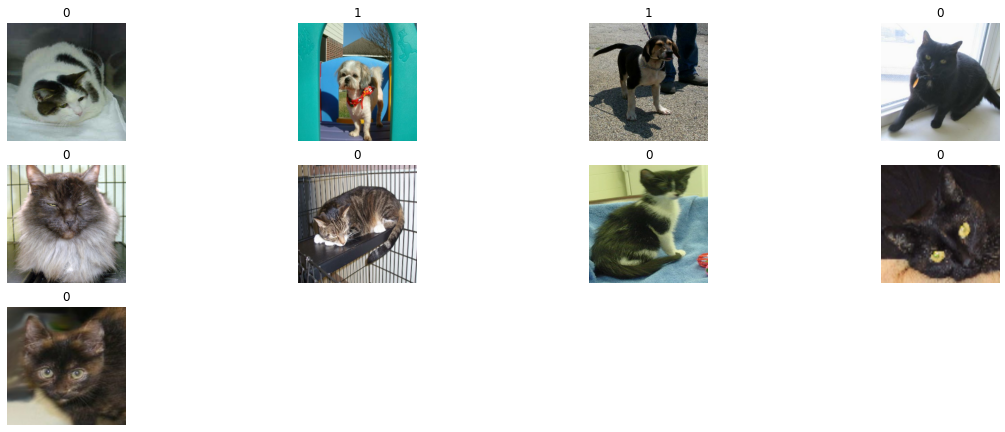

In [154]:

plt.figure(figsize=(20, 10))
for images, labels in data_pet.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [155]:

batch_size = 64
img_height = 128
img_width = 128

In [156]:

import os
images_skip = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_pet_direct, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            images_skip += 1
            os.remove(fpath)
print("Deleting %d images" % images_skip)


Deleting 1590 images


In [157]:
#Data augmentation
images_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])


In [158]:

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet_direct,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validating_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet_direct,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [179]:
cl_names = training_data.class_names
print(cl_names)
cl_names = validating_data.class_names
print(cl_names)

['Cat', 'Dog']
['Cat', 'Dog']


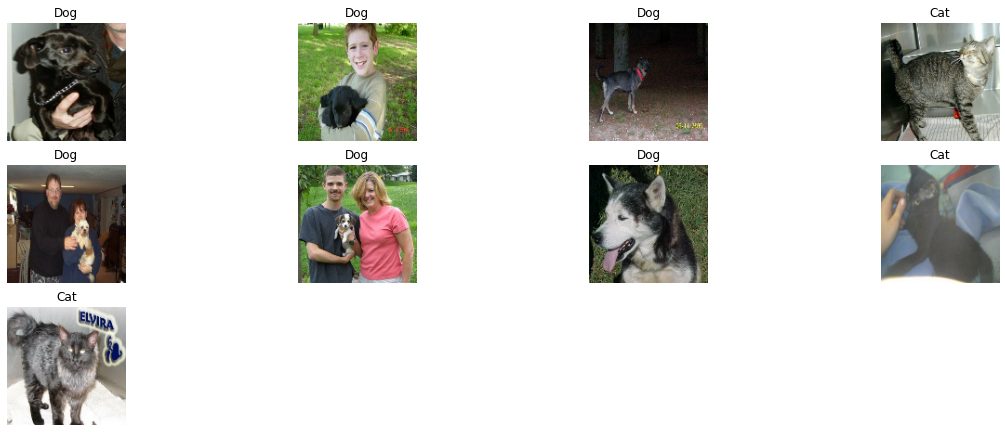

In [180]:
plt.figure(figsize=(20, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cl_names[labels[i]])
    plt.axis("off")

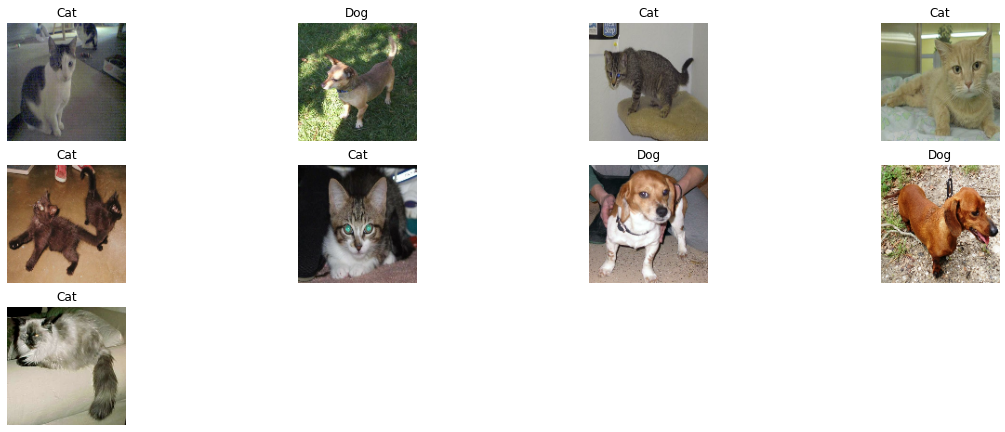

In [182]:
plt.figure(figsize=(20, 10))
for images, labels in validating_data.take(1):
  for i in range(9):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cl_names[labels[i]])
    plt.axis("off")

In [183]:
for image_batch, labels_batch in training_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 128, 128, 3)
(64,)


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [184]:
first_model = tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255), 
                                    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.25),
                                    
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(2, activation = 'softmax')])

In [185]:
first_model.compile(
  optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [186]:
history = first_model.fit(training_data, validation_data=validating_data, epochs=50)

Epoch 1/50
257/257 [==============================] - 39s 112ms/step - loss: 0.8097 - accuracy: 0.6260 - val_loss: 0.6644 - val_accuracy: 0.6121
Epoch 2/50
257/257 [==============================] - 29s 112ms/step - loss: 0.5504 - accuracy: 0.7234 - val_loss: 0.6045 - val_accuracy: 0.6967
Epoch 3/50
257/257 [==============================] - 29s 110ms/step - loss: 0.4682 - accuracy: 0.7812 - val_loss: 0.5218 - val_accuracy: 0.7225
Epoch 4/50
257/257 [==============================] - 30s 114ms/step - loss: 0.4113 - accuracy: 0.8170 - val_loss: 1.1940 - val_accuracy: 0.6715
Epoch 5/50
257/257 [==============================] - 29s 109ms/step - loss: 0.3679 - accuracy: 0.8379 - val_loss: 0.7144 - val_accuracy: 0.7578
Epoch 6/50
257/257 [==============================] - 29s 109ms/step - loss: 0.3224 - accuracy: 0.8632 - val_loss: 1.0665 - val_accuracy: 0.8012
Epoch 7/50
257/257 [==============================] - 29s 110ms/step - loss: 0.2853 - accuracy: 0.8775 - val_loss: 1.8937 - val_ac

In [187]:
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_1410 (Conv2D)        (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_1410 (B  (None, 126, 126, 32)     128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1411 (Conv2D)        (None, 61, 61, 64)       

In [188]:
first_model.evaluate(validating_data)

110/110 [==============================] - 8s 67ms/step - loss: 1.2665 - accuracy: 0.8660


[1.2664552927017212, 0.8660116791725159]

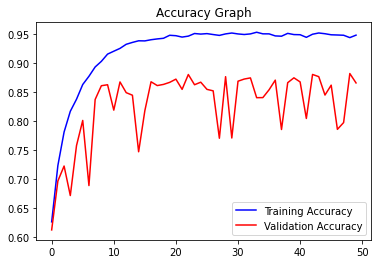

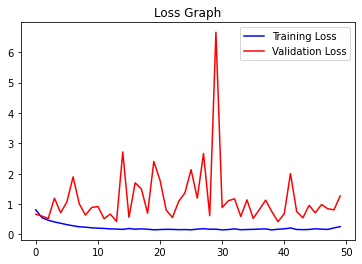

In [189]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [190]:
import os
import shutil
import glob
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image

In [191]:
pre_trained = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)